In [28]:
import sys
import os

In [29]:
## adding scripts to path
sys.path.append("../scripts")

In [3]:
from model import GCDDDetector
import config
from datasets import ImageDataset, ImagePredictionDataset
from _utils import get_labelencoder, get_transforms, get_test_transforms, get_means_and_stds, clean_bbox_data
import pandas as pd
import numpy as np
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import ToTensor
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.ops import nms
from torchvision.transforms import v2 as T
import torchvision
from torchvision.models import MobileNet_V3_Large_Weights


In [27]:

temp = clean_bbox_data(df_train)
temp[temp["class"]=="Pepper_Early_Blight"]

,Image_ID,confidence,class,ymin,xmin,ymax,xmax
1562,id_2vs7io.jpg,1.0,Pepper_Early_Blight,732.181352,1804.419008,926.714139,1963.951712
1563,id_2vs7io.jpg,1.0,Pepper_Early_Blight,1106.460553,1961.199956,1303.856557,2182.667910
1565,id_2vs7io.jpg,1.0,Pepper_Early_Blight,1489.827357,2455.105575,1664.442111,2561.981563
3168,id_4mxj4g.jpg,1.0,Pepper_Early_Blight,1982.508197,778.401229,2192.214652,991.503292
3171,id_4mxj4g.jpg,1.0,Pepper_Early_Blight,2013.491803,1478.176910,2207.651127,1826.764925
...,...,...,...,...,...,...,...
40003,id_ywr9iw.jpg,1.0,Pepper_Early_Blight,1598.518955,1001.113696,1952.644980,1521.900790
40164,id_4mxj4g.jpg,1.0,Pepper_Early_Blight,2397.619365,1688.900571,2548.194160,1919.937445
40485,id_z4yaxx.jpg,1.0,Pepper_Early_Blight,1612.240266,1877.817603,1826.165471,2215.384767
40570,id_2vs7io.jpg,1.0,Pepper_Early_Blight,1441.415471,1156.345917,1728.525615,1662.309482


In [4]:
def compare_imgs(img1, img2):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,9))
    ax1.imshow(img1)
    ax2.imshow(img2)
    plt.show()

def draw_boxes(image, target, width=4, color=None):
    font = "/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf"
    boxes = target["boxes"]
    labels = target["labels"]
    return draw_bounding_boxes(image, boxes, [str(label.item()) for label in labels], width=width, font=font, font_size=50, colors=[color] * len(labels))

def compare_single(image, target_gt, target_pred):
    image = draw_boxes(image, target_gt, color="#8934eb") ## target
    image = draw_boxes(image, target_pred, color="#eb4034") ## pred
    return image.permute(1,2,0)

def box_nms(preds, threshold):
        new_preds = []

        for pred in preds:
            keep_idxs = nms(pred["boxes"], pred["scores"], threshold)
            new_pred = {}
            new_pred["boxes"] = pred["boxes"][keep_idxs]
            new_pred["labels"] = pred["labels"][keep_idxs]
            new_pred["scores"] = pred["scores"][keep_idxs]
            new_preds.append(new_pred)

        return new_preds

# def get_transforms():
#     scale_transform = T.Lambda(lambda x: x/255.0, torchvision.tv_tensors._image.Image)
#     return T.Compose([
#         # T.RandomResizedCrop(256, scale=(0.8,1)),
#         T.ToImage(),
#         T.ColorJitter(),
#         T.RandomHorizontalFlip(),
#         T.RandomVerticalFlip(),
#         T.ToDtype(torch.float32, scale=True),
#         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])

In [5]:
CHECKPOINT_NAME="epoch-epoch=00_map@50=map_50=0.20.ckpt"
CHECKPOINT_PATH = os.path.join("../checkpoints/", CHECKPOINT_NAME)
DATA_PATH = "../data"
ANNOT_PATH = os.path.join(DATA_PATH, "Train.csv")
IMGS_DIR = os.path.join(DATA_PATH, "images")

In [6]:
temp = clean_bbox_data(pd.read_csv(ANNOT_PATH))
temp["width"] = temp["xmax"] - temp["xmin"]
temp["height"] = temp["ymax"] - temp["ymin"]
temp["aspect"] = temp["width"]/temp["height"]

temp.min()

Image_ID                  id_11543h.jpg
confidence                          1.0
class         Corn_Cercospora_Leaf_Spot
ymin                                0.0
xmin                                0.0
ymax                          31.572165
xmax                          26.296875
width                          6.428571
height                         5.584239
aspect                         0.500039
dtype: object

In [7]:
# model = GCDDDetector.load_from_checkpoint(CHECKPOINT_PATH,
#                                                   num_classes=24,
#                                                   learning_rate=0.002,
#                                                   trainable_backbone_layers=3,
#                                                   map_location="cpu"
#                                                  )
model = GCDDDetector(24,
                             learning_rate=config.LEARNING_RATE,
                             # trainable_backbone_layers=config.TRAINABLE_BACKBONE_LAYERS
                    )
model.eval();

In [8]:
## data
df_train = pd.read_csv(ANNOT_PATH)
df = df_train[df_train["class"] == "Corn_Cercospora_Leaf_Spot"]

In [9]:
label_encoder = get_labelencoder(ANNOT_PATH, "class")
transforms = get_test_transforms()
dataset = ImageDataset(df, IMGS_DIR, label_encoder=get_labelencoder(ANNOT_PATH, "class"), transforms=get_transforms())

/home/jovyan/work/Crop_Disease_Detection/notebooks/../scripts/datasets.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["class"] = self.class_encoder.transform(self.df["class"])


In [10]:
rand_index = np.random.randint(0, len(dataset))
image, target = dataset[rand_index]
target

{'boxes': tensor([[2003.9661,  459.1073, 2081.1450,  535.2920],
         [2025.3682,  563.5822, 2113.3872,  637.5117]]),
 'labels': tensor([1, 1])}

/opt/conda/lib/python3.11/site-packages/torchvision/utils.py:211: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


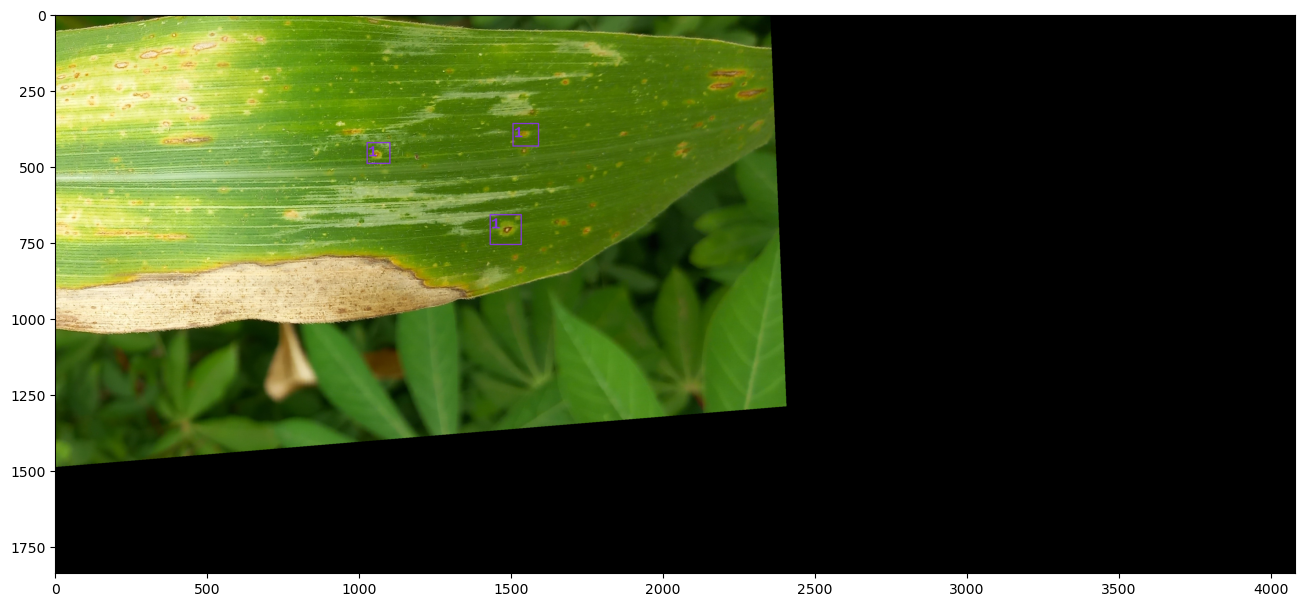

In [11]:
# rand_index = np.random.randint(0, len(dataset))
# rand_index = 0
# image, target = dataset[rand_index]
image, target = dataset[rand_index]

with torch.no_grad():
    preds = model([transforms(image)])[0]
    preds = box_nms([preds], 0.01)[0]
    
# img_with_gt = draw_boxes(image, target)
# img_with_pred = draw_boxes(image, preds)



# compare_imgs(img_with_gt.permute(1,2, 0).numpy(), img_with_pred.permute(1,2,0).numpy())
# F.to_pil_image(img_with_gt)

fig = plt.figure(figsize=(16,9))
plt.imshow(compare_single(image, target, preds))
plt.show()

In [24]:
label_encoder.inverse_transform([0,4])

KeyError: 0

In [ ]:
#1106
len(preds["scores"])

In [ ]:
# item = fasterrcnn_mobilenet_v3_large_fpn(
#     weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1
#     rpn_anchor_boxes=AnchorGenerator(sizes=config.ANCHOR_SIZES, aspect_ratios=config.ANCHOR_RATIOS),
#                                         )

In [ ]:
(image.permute(1,2,0).numpy()/255.0).std(axis=(0,1))

In [ ]:
get_means_and_stds(ANNOT_PATH, IMGS_DIR)

In [ ]:
temp = df_train.drop_duplicates(subset=["Image_ID"], keep="last")
temp=temp.groupby("class").sample(n=6, random_state=config.SEED)
temp.to_csv("../data/train_vs.csv", index=False)

In [ ]:
temp

In [6]:
encoder = get_labelencoder(ANNOT_PATH, "class")

In [7]:
encoder.transform(["Tomato_Fusarium", "Corn_Streak"])
encoder.inverse_transform([1, 13])

['Corn_Cercospora_Leaf_Spot', 'Pepper_Leaf_Curl']

In [8]:
encoder.holder

{'Corn_Cercospora_Leaf_Spot': 1,
 'Corn_Common_Rust': 2,
 'Corn_Healthy': 3,
 'Corn_Northern_Leaf_Blight': 4,
 'Corn_Streak': 5,
 'Pepper_Bacterial_Spot': 6,
 'Pepper_Cercospora': 7,
 'Pepper_Early_Blight': 8,
 'Pepper_Fusarium': 9,
 'Pepper_Healthy': 10,
 'Pepper_Late_Blight': 11,
 'Pepper_Leaf_Blight': 12,
 'Pepper_Leaf_Curl': 13,
 'Pepper_Leaf_Mosaic': 14,
 'Pepper_Septoria': 15,
 'Tomato_Bacterial_Spot': 16,
 'Tomato_Early_Blight': 17,
 'Tomato_Fusarium': 18,
 'Tomato_Healthy': 19,
 'Tomato_Late_Blight': 20,
 'Tomato_Leaf_Curl': 21,
 'Tomato_Mosaic': 22,
 'Tomato_Septoria': 23}

In [9]:
encoder.holder_inverse

{1: 'Corn_Cercospora_Leaf_Spot',
 2: 'Corn_Common_Rust',
 3: 'Corn_Healthy',
 4: 'Corn_Northern_Leaf_Blight',
 5: 'Corn_Streak',
 6: 'Pepper_Bacterial_Spot',
 7: 'Pepper_Cercospora',
 8: 'Pepper_Early_Blight',
 9: 'Pepper_Fusarium',
 10: 'Pepper_Healthy',
 11: 'Pepper_Late_Blight',
 12: 'Pepper_Leaf_Blight',
 13: 'Pepper_Leaf_Curl',
 14: 'Pepper_Leaf_Mosaic',
 15: 'Pepper_Septoria',
 16: 'Tomato_Bacterial_Spot',
 17: 'Tomato_Early_Blight',
 18: 'Tomato_Fusarium',
 19: 'Tomato_Healthy',
 20: 'Tomato_Late_Blight',
 21: 'Tomato_Leaf_Curl',
 22: 'Tomato_Mosaic',
 23: 'Tomato_Septoria'}